# Simple Model By Hand

In [126]:
import pandas as pd
pd.set_option("max_colwidth", None)

import pycaret
import numpy as np
import matplotlib.pyplot as plt
from pycaret.classification import * 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from functions.homebrew import *
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from itertools import combinations
import pickle
import os

# If you're using statsmodels or ISLP for specific tasks, keep these imports
import statsmodels.api as sm
# Assuming ISLP and homebrew are custom modules specific to your project
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS, summarize, contrast
import statsmodels.api as sm
from scipy import stats

# Helper Functions

In [127]:
def convert_confusion_matrix(df, name):
    """
    Converts a confusion matrix dataframe into a format with columns for model name, TP, TN, FP, FN.
    
    Args:
    df (pd.DataFrame): Confusion matrix dataframe with multi-index (Truth, Predicted) and columns [0, 1].
    
    Returns:
    pd.DataFrame: Reformatted dataframe with model evaluation metrics.
    """
    # Extracting the values from the confusion matrix
    tn, fp, fn, tp = df.iloc[0, 0], df.iloc[0, 1], df.iloc[1, 0], df.iloc[1, 1]
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp +fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((prec * recall)/(prec + recall))
    # Creating a new dataframe with the desired format
    metrics_df = pd.DataFrame({
        "name": name,
        "tp": [tp],
        "tn": [tn],
        "fp": [fp],
        "fn": [fn],
        'acc': acc,
        'prec': prec,
        'recall': recall,
        'f1': f1
    })
    
    return metrics_df

In [128]:
def format_results(df):
    df = np.where(df == 1, 'Donor','No Donor')
    return df

# LOAD DATA

In [140]:
df = pd.read_csv('./data/df.csv').drop('Unnamed: 0', axis=1)

In [141]:
train = df[df['type'] == 'train'].drop('type',axis =1)
dev = df[df['type'] == 'dev'].drop('type',axis =1)
test = df[df['type'] == 'test'].drop('type',axis =1)

# VIF

In [142]:
dummies = pd.get_dummies(df, drop_first=True)

kept, removed = remove_high_vif_features(X=dummies.drop('target_No Donor', axis=1), y=dummies['target_No Donor'], vif_threshold=10)
print('REMOVED:', removed)

REMOVED: ['avg_fam_inc', 'months_since_donate', 'zipconvert5_Yes', 'med_fam_inc', 'avg_gift']


In [144]:
kept['target'] = (df['target'] == 'Donor').astype(int)

In [145]:
train = kept[kept['type_train'] ==1]
dev = kept[(kept['type_test'] == 0) & (kept['type_train'] == 0)]
test = kept[kept['type_test'] ==1]

In [154]:
# for data in [train, dev, test]:
#     data.drop('type_train', inplace = True, axis = 1)
#     data.drop('type_test', inplace = True, axis = 1)
test = test.drop('target',axis = 1)

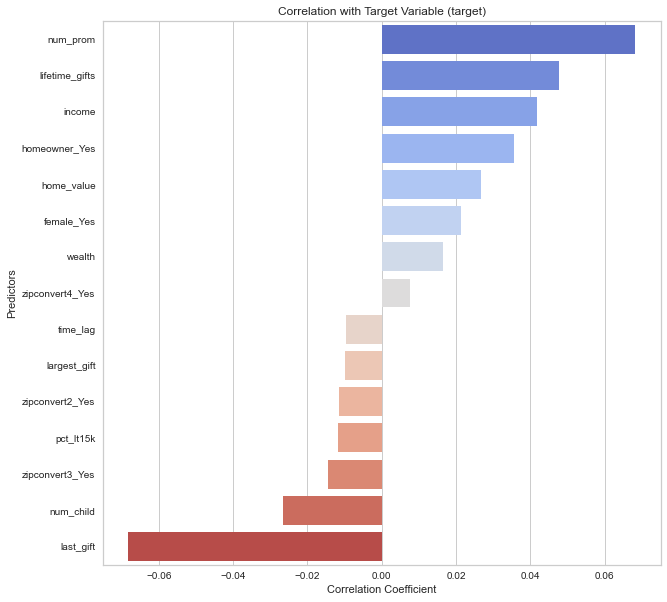

In [174]:
def cor_bars(df):
    corr = df.corr()
    # Isolating the column that represents the correlation with the target variable
    target_corr = corr['target'].sort_values(ascending=False)

    # Removing the target variable from itself to avoid a perfect correlation display
    target_corr = target_corr.drop(labels=['target'])

    # Plotting the correlations for visual representation
    plt.figure(figsize=(10, 10))
    sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
    plt.title('Correlation with Target Variable (target)')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Predictors')
    plt.show()
cor_bars(train)

# Logistic Regression

In [155]:
for col in kept.columns:
    print(col)

num_child
income
wealth
home_value
pct_lt15k
num_prom
lifetime_gifts
largest_gift
last_gift
time_lag
zipconvert2_Yes
zipconvert3_Yes
zipconvert4_Yes
homeowner_Yes
female_Yes
type_test
type_train
target


In [156]:
results_df = pd.DataFrame()

In [157]:
# Selecting features and target variable for training data
X_train = train.drop(['target'], axis =1 )
y_train = train['target']
X_test = dev.drop(['target'], axis = 1)
y_test = dev['target']

# Fitting logistic regression model
glm = sm.GLM(y_train, X_train, family=sm.families.Binomial())
glm = glm.fit()

# Summarizing results
# print(results.summary())

In [158]:
log_preds = (glm.predict(X_test) >= 0.5).astype(int)
log_acc = accuracy_score(log_preds, y_test)
print(log_acc)

d = confusion_table(log_preds,y_test)
results_df = pd.concat([results_df,convert_confusion_matrix(d, 'Logistic Regression')])

log_test_preds = (glm.predict(test) >= 0.5).astype(int)
log_test_preds = format_results(log_test_preds)

save_df = pd.DataFrame(log_test_preds, columns=['values'])
save_df.to_csv('./preds/log.csv', index=False)

0.53


### LDA

In [159]:
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)

lda_preds = lda.predict(X_test)

lda_acc = accuracy_score(lda_preds,y_test)
print(lda_acc)

d = confusion_table(lda_preds,y_test)
results_df = pd.concat([results_df,convert_confusion_matrix(d, 'LDA')])


lda_test_preds = (lda.predict(test) >= 0.5).astype(int)
lda_test_preds = format_results(lda_test_preds)

save_df = pd.DataFrame(lda_test_preds, columns=['values'])
save_df.to_csv('./preds/lda.csv', index=False)

0.5483333333333333


# QDA.


In [160]:
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)

qda_preds = qda.predict(X_test)

qda_acc = accuracy_score(qda_preds,y_test)

print(qda_acc)

d = confusion_table(qda_preds,y_test)
results_df = pd.concat([results_df,convert_confusion_matrix(d, 'QDA')])

qda_test_preds = (qda.predict(test) >= 0.5).astype(int)
qda_test_preds = format_results(qda_test_preds)

save_df = pd.DataFrame(qda_test_preds, columns=['values'])
save_df.to_csv('./preds/qda.csv', index=False)

0.49


# KNN

In [161]:
df['type']

0       train
1       train
2         dev
3       train
4       train
        ...  
3115     test
3116     test
3117     test
3118     test
3119     test
Name: type, Length: 3120, dtype: object

In [162]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
knn1_acc = accuracy_score(knn1_pred,y_test)

print(knn1_acc)
                         
d = confusion_table(knn1_pred, y_test)
results_df = pd.concat([results_df,convert_confusion_matrix(d, 'KNN')])

knn1_test_preds = (knn1.predict(test) >= 0.5).astype(int)
knn1_test_preds = format_results(knn1_test_preds)

save_df = pd.DataFrame(knn1_test_preds, columns=['values'])
save_df.to_csv('./preds/knn1.csv', index=False)

0.5016666666666667


# NB


In [163]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)
nb_acc = accuracy_score(nb_preds,y_test)

print(nb_acc)
save_df = pd.DataFrame(nb_preds, columns=['values'])
save_df.to_csv('./preds/nb.csv', index=False)

d = confusion_table(nb_preds, y_test)
results_df = pd.concat([results_df,convert_confusion_matrix(d, 'Naïve Bayes')])

nb_test_preds = (nb.predict(test) >= 0.5).astype(int)
nb_test_preds = format_results(nb_test_preds)

save_df = pd.DataFrame(nb_test_preds, columns=['values'])
save_df.to_csv('./preds/nb.csv', index=False)

0.5016666666666667


In [1]:
# results_df

In [168]:
test_acc = { # these are from running on the website
    'log': 0.5333333,
    'lda': 0.5583333,
    'qda': 0.525,
    'knn':  0.475,
    'nb': 0.5166667,
}

In [169]:
results_df['test_acc'] = test_acc.values()

In [170]:
results_df

,name,tp,tn,fp,fn,acc,prec,recall,f1,test_acc
0,Logistic Regression,167,151,145,137,0.530000,0.535256,0.549342,0.542208,0.533333
0,LDA,163,166,149,122,0.548333,0.522436,0.571930,0.546064,0.558333
0,QDA,26,268,286,20,0.490000,0.083333,0.565217,0.145251,0.525000
0,KNN,148,153,164,135,0.501667,0.474359,0.522968,0.497479,0.475000
0,Naïve Bayes,38,263,274,25,0.501667,0.121795,0.603175,0.202667,0.516667
